# BPL_CHO_Fedbatch demo

In [1]:
run -i BPL_CHO_fedbatch_explore.py

Linux - run FMU pre-comiled JModelica 2.4

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values / units

Note that both disp() and describe() takes values from the last simulation

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
plt.rcParams['figure.figsize'] = [30/2.54, 24/2.54]

Simulation interval    : 0.0 - 200.00000000000003 seconds.
Elapsed simulation time: 0.028425254000467248 seconds.


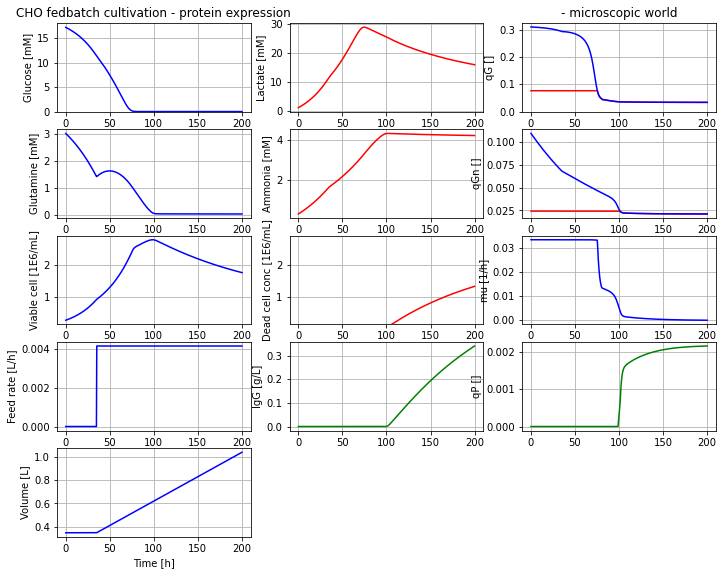

In [3]:
# Slide 3
newplot('CHO fedbatch cultivation - protein expression', plotType='Textbook_3')

# Data from Table 1 and 2 for experiment 3
V_0=0.35
init(V_0=V_0, VXv_0=V_0*0.29, VXd_0=V_0*0.010)
init(VG_0=V_0*17.17, VGn_0=V_0*3.02, VL_0=V_0*1.12, VN_0=V_0*0.29)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=35, F1=Feed, t2=100, F2=Feed)
par(t3=300, F3=Feed)

# Culture parameters
par(alpha=-1.0, beta=0.01)

# Simulation
simu(200)
#par(t2=100, F2=0.7*Feed, t3=300, F3=0.7*Feed); simu(200)
#par(F2=Feed, F3=Feed)

In [4]:
system_info()


System information
 -OS: Linux
 -Python: 3.8.2
 -PyFMI: 2.7.4
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: FMUModelCS2
 -Name: BPL_CHO.Fedbatch
 -Generated: 2022-08-29T12:13:26
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.1.0 beta
 -Interaction: FMU-explore ver 0.9.2
